# Определение возраста покупателей

Необходимо построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей. Значение MAE на тестовой выборке не должно превышать 8.

## Исследовательский анализ данных

In [1]:
# импортируем модули и функции
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

## скрываем предупреждения--------------------------------------------------------------

np.warnings = warnings
warnings.filterwarnings('ignore')

In [2]:
# загружаем названия фотографий и возраст
labels = pd.read_csv('labels.csv')

# берем за 1 итерацию по несколько фото, чтобы не перегружать оперативную память
# с помощью ImageDataGenerator

# выражаем значение канала в долях единицы
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
    
        # папка, в которой хранится датасет
        directory='final_files/',
    
        # сопоставляем имена файлов с информацией о возрасте
        x_col='file_name',
        y_col='real_age',
    
        # приводим фото к единому размеру
        target_size=(224, 224),
    
        # размер батча
        batch_size=32,
    
        # метки классов выводим как есть
        class_mode='raw',
        
        # фиксируем генератор случайных чисел
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# выведем общую информацию о выборке
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# выведем первые строки датафрейма
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


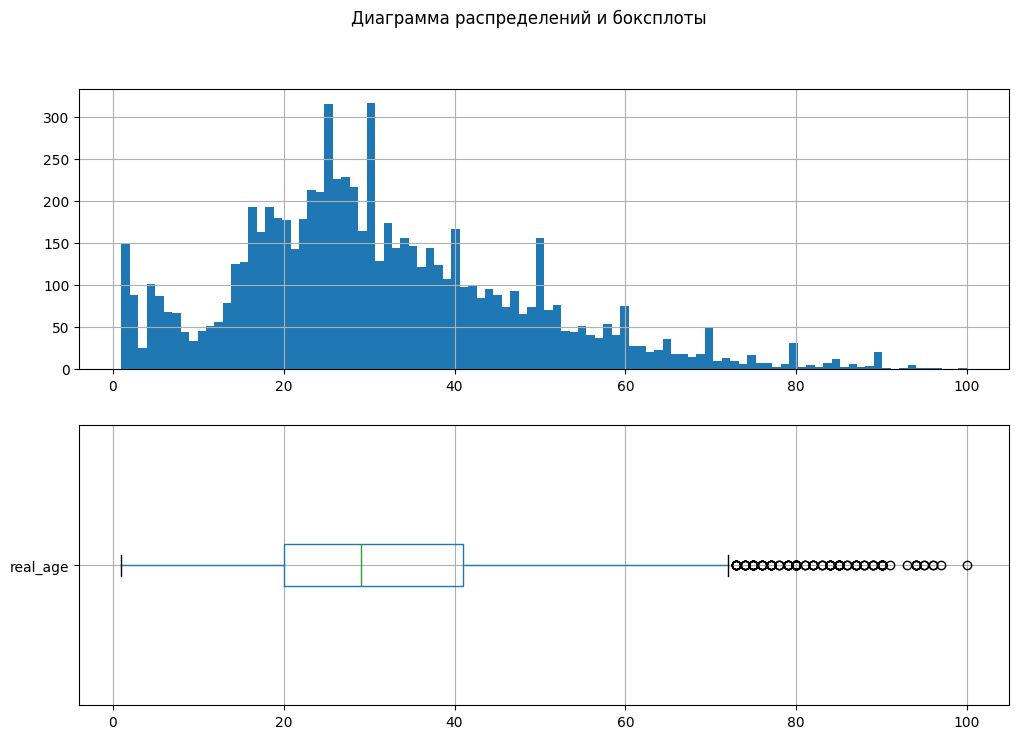

Основные описательные статистики:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [5]:
def plot_hist_boxplot(df, 
                      column, 
                      title = 'Диаграмма распределений и боксплоты', 
                      bins = [100, 100]):

    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    axes[0].hist(df[column], bins = bins[0], alpha = 1)
    axes[0].grid()

    df.boxplot(column, ax = axes[1], vert = False)
    fig.suptitle(title)

    plt.show()
    
    # получим описательные статистики
    print('Основные описательные статистики:')
    print(df[column].describe())


plot_hist_boxplot(labels, 'real_age')

В нашем распоряжении 7591 размеченная фотография. 

Общее эмпирическое правило (основанное на материалах книги Фрэнка Харрелла "Стратегии регрессионного моделирования") заключается в том, что нужно оценить 10-20 наблюдений на каждый параметр (ковариацию).

В нашем случае параметр - это возраст человека от 1 до 100 лет. Выходит, что всего наблюдений требуется в районе 1000-2000 при условии, что на каждый возраст приходится как минимум 10 фотографий.

Как видим из гистограммы в выборке мало фотографий людей старше 70 лет. Следовательно предсказание возраста для данной группы людей может быть менее точное. Для повышения качества прогнозов необходимо увеличить количество фотографий людей старше 70 лет. Когда данных слишком мало большого эффекта от агументации ожидать не приходится.

Выведем 15 случайных фотографий.

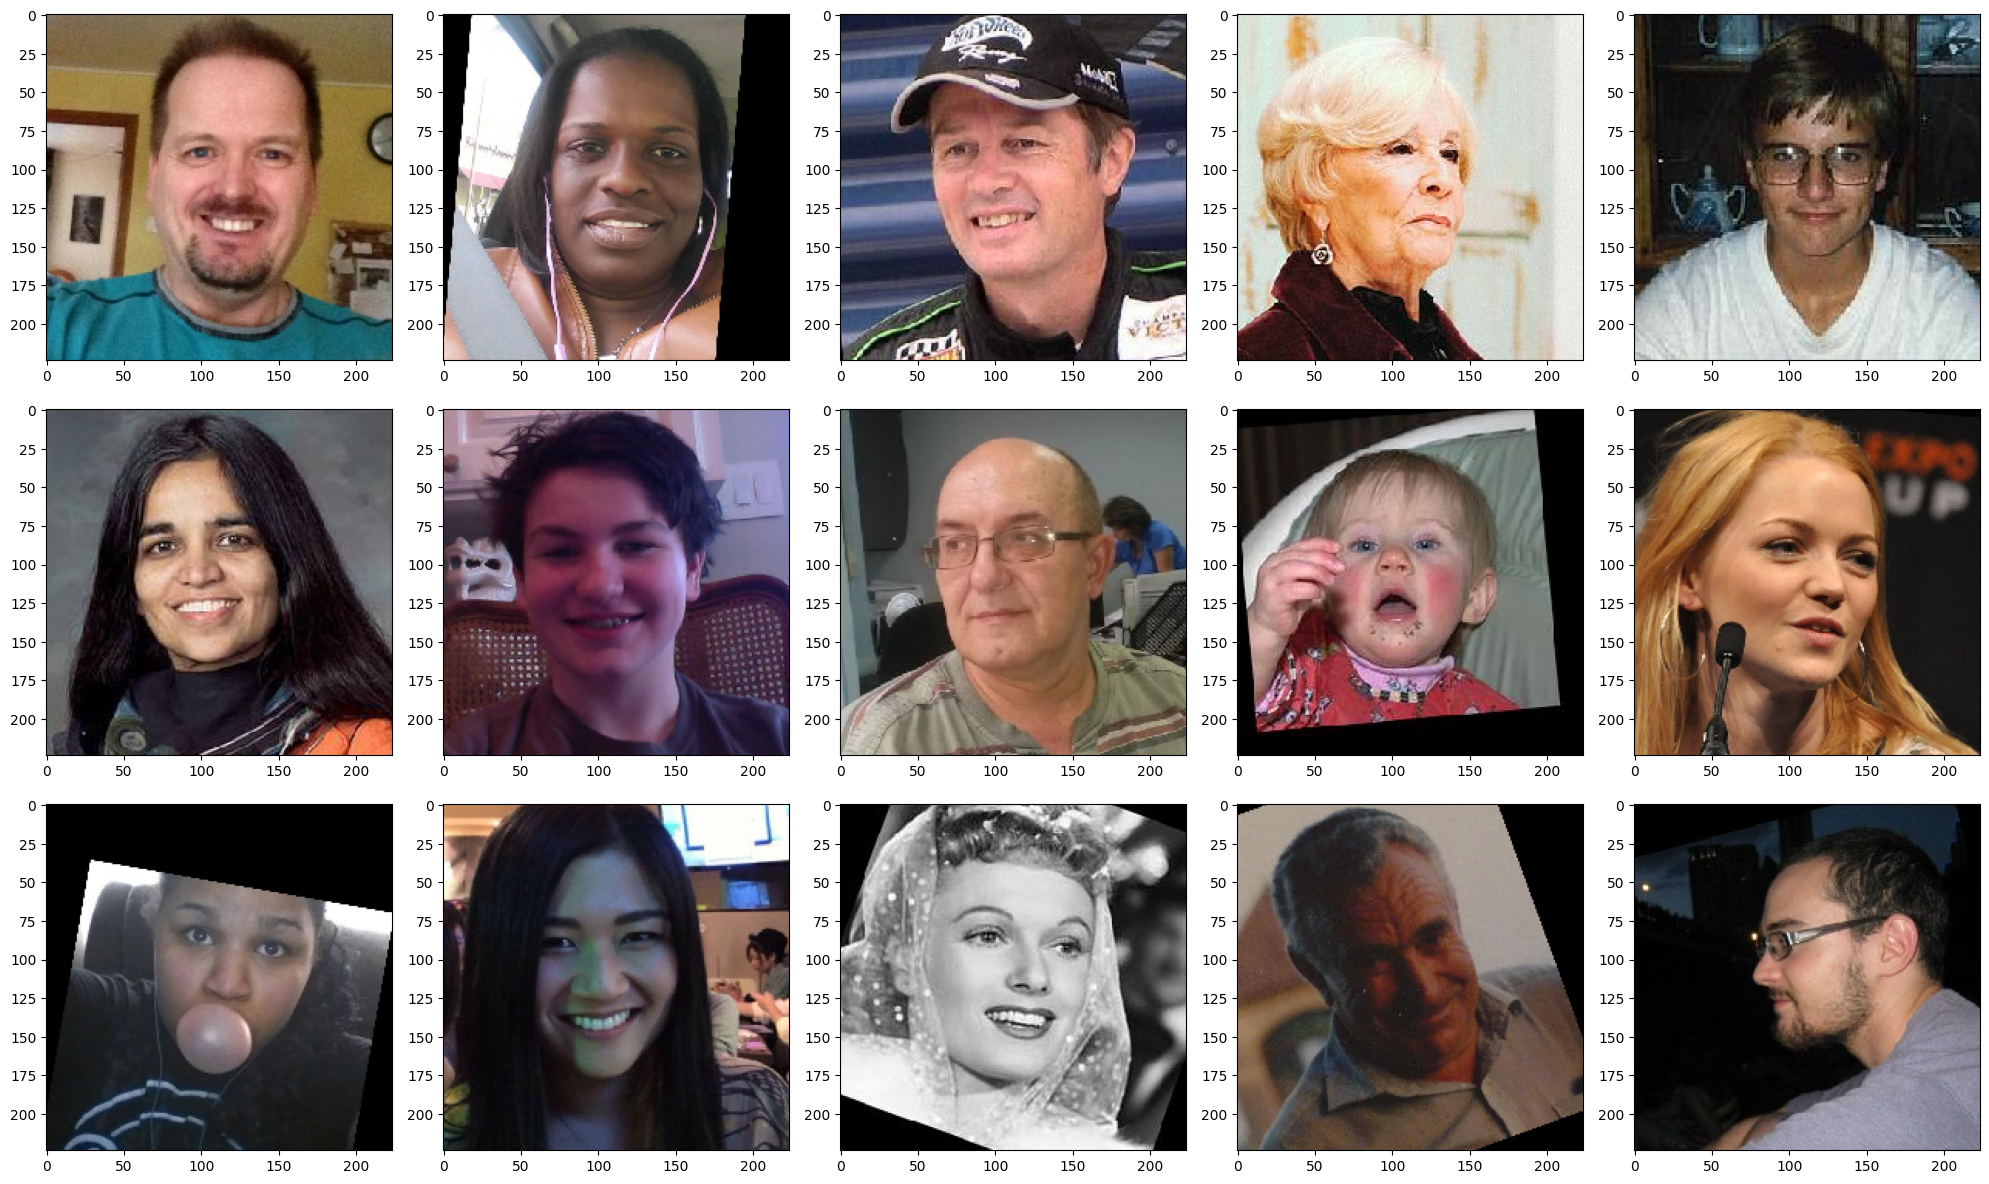

In [6]:
# Функция next возвращает блок изображений из набора данных. 
# Один блок представляет собой кортеж (множество изображений, множество меток). 
sample_training_images, age = next(datagen_flow)

# данная функция отрисует изображения в сетке размером 3х5
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# отрисовываем изображения 0-15
plotImages(sample_training_images[:15]) 

In [7]:
# выведем возраст людей в соответствии с порядком фотографий
np.reshape(age[:15], (3, 5))

array([[50, 41, 46, 85, 14],
       [40, 14, 53,  4, 32],
       [14, 23, 37, 62, 21]], dtype=int64)

**Итог:**

- В выборке 7591 размеченных фотографий.
- Возраст людей находится в диапазоне от 1 до 100 лет. 
- Средний возраст составляет 31,2 года. 
- Половина людей выборки в возрасте от 20 до 41 года. 
- На гистограмме возраста видны пики и провалы, данные распределены неравномерно, характер распределения не является нормальным. 
- Для повышения качества прогнозов необходимо увеличить количество фотографий людей старше 70 лет.
- Вероятно данные были предобработаны в автоматизированном режиме: фотографии обрезаны, чтобы были видны только лица и приведены в вертикальное положение путем поворота. Некоторые фотографии остались расположены под углом, а так же не обрезаны (например, люди изображены в полный рост). Это говорит о том, что обучающая выборка неидеальна и для более точных прогнозов можно улучшить её качество.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
# импортируем необходимые модули
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

# функция для загрузки тренировочного датасета
def load_train(path):
    
    # загружаем названия фотографий и возраст
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1. / 255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,

        # папка, в которой хранится датасет
        directory=path + 'final_files/',

        # сопоставляем имена файлов с информацией о возрасте
        x_col='file_name',
        y_col='real_age',

        target_size=(224, 224),
        batch_size=16,

        # метки классов выводим как есть
        class_mode='raw',

        subset='training',
        seed=12345)

    return train_datagen_flow
# -------------------------------------------------------------------

# функция для загрузки валидационного датасета
def load_test(path):
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255)

    # загружаем названия фотографий и возраст
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow
# -------------------------------------------------------------------

# функция для создания модели нейросети
def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)
    activation = 'relu'

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)

    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=144, activation=activation))
    model.add(Dense(units=48, activation=activation))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model
# -------------------------------------------------------------------

# функция для обучения нейросети
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Вывод результатов работы модели.

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 67s - loss: 191.5187 - mae: 10.1867 - val_loss: 357.1792 - val_mae: 14.0528
Epoch 2/5
356/356 - 44s - loss: 79.8223 - mae: 6.7842 - val_loss: 141.1292 - val_mae: 9.0072
Epoch 3/5
356/356 - 56s - loss: 50.2927 - mae: 5.4041 - val_loss: 114.2597 - val_mae: 8.3380
Epoch 4/5
356/356 - 49s - loss: 38.1843 - mae: 4.7129 - val_loss: 72.1440 - val_mae: 6.3304
Epoch 5/5
356/356 - 42s - loss: 29.6328 - mae: 4.1443 - val_loss: 71.1377 - val_mae: 6.4450
119/119 - 10s - loss: 71.1377 - mae: 6.4450
Test MAE: 6.4450
```

**Итог:**

- Нейронная сеть обучена. Ошибок не обнаружено.
- MAE = 6.445, что удовлетворяет требованиям задания (не больше 8).

## Анализ обученной модели

**В ходе проекта мы провели следующую работу:**

- изучили данные;


- подготовили модель на основе ResNet50 для дальнейшего расчета в Yandex Cloud.


- произвели обучение модели в облачном сервере и получили результаты.


**Результаты:**

- Нейронная сеть обучена. Ошибок не обнаружено.


- После 5 эпох обучения нейросеть показала MAE на тестовых данных: 6.445 лет, что удовлетворяет требованиям задания (не превышает 8).


- Требуемая точность достигнута менее чем за 5 минут обучения. При необходимости сеть можно усовершенствовать, для этого можно выполнить следующие шаги: 


    - увеличить число эпох обучения;
    - добавить новые или расширить существующие полносвязные слои нейронов;
    - подобрать оптимальный параметр `learning rate`;
    - расширить обучающую выборку, добавив дополнительные преобразования существующих фотографий в `ImageDataGenerator`;
    - улучшить качество обучающей выборки;
    - увеличить количество фотографий людей старше 70 лет.